In [1]:
#!/usr/bin/env python3.4

import os
import sys
import re
import uuid
import random
import imageio
import numpy as np
import torch
import torch_scatter

from scipy import misc
from PIL import Image
from tqdm import tqdm
from IPython import display

import matplotlib.pyplot as plt

def as_gif(images, path="temp.gif"):
  # Render the images as the gif (15Hz control frequency):
  images[0].save(path, save_all=True, append_images=images[1:], duration=int(1000/15), loop=0)
  gif_bytes = open(path,"rb").read()
  return gif_bytes

def read(file):
    if file.endswith('.float3'): return readFloat(file)
    elif file.endswith('.flo'): return readFlow(file)
    elif file.endswith('.ppm'): return readImage(file)
    elif file.endswith('.pgm'): return readImage(file)
    elif file.endswith('.png'): return readImage(file)
    elif file.endswith('.jpg'): return readImage(file)
    elif file.endswith('.pfm'): return readPFM(file)[0]
    else: raise Exception('don\'t know how to read %s' % file)

def write(file, data):
    if file.endswith('.float3'): return writeFloat(file, data)
    elif file.endswith('.flo'): return writeFlow(file, data)
    elif file.endswith('.ppm'): return writeImage(file, data)
    elif file.endswith('.pgm'): return writeImage(file, data)
    elif file.endswith('.png'): return writeImage(file, data)
    elif file.endswith('.jpg'): return writeImage(file, data)
    elif file.endswith('.pfm'): return writePFM(file, data)
    else: raise Exception('don\'t know how to write %s' % file)

def readPFM(file):
    file = open(file, 'rb')

    color = None
    width = None
    height = None
    scale = None
    endian = None

    header = file.readline().rstrip()
    if header.decode("ascii") == 'PF':
        color = True
    elif header.decode("ascii") == 'Pf':
        color = False
    else:
        raise Exception('Not a PFM file.')

    dim_match = re.match(r'^(\d+)\s(\d+)\s$', file.readline().decode("ascii"))
    if dim_match:
        width, height = list(map(int, dim_match.groups()))
    else:
        raise Exception('Malformed PFM header.')

    scale = float(file.readline().decode("ascii").rstrip())
    if scale < 0: # little-endian
        endian = '<'
        scale = -scale
    else:
        endian = '>' # big-endian

    data = np.fromfile(file, endian + 'f')
    shape = (height, width, 3) if color else (height, width)

    data = np.reshape(data, shape)
    data = np.flipud(data)
    return data, scale

def writePFM(file, image, scale=1):
    file = open(file, 'wb')

    color = None

    if image.dtype.name != 'float32':
        raise Exception('Image dtype must be float32.')

    image = np.flipud(image)

    if len(image.shape) == 3 and image.shape[2] == 3: # color image
        color = True
    elif len(image.shape) == 2 or len(image.shape) == 3 and image.shape[2] == 1: # greyscale
        color = False
    else:
        raise Exception('Image must have H x W x 3, H x W x 1 or H x W dimensions.')

    file.write('PF\n' if color else 'Pf\n'.encode())
    file.write('%d %d\n'.encode() % (image.shape[1], image.shape[0]))

    endian = image.dtype.byteorder

    if endian == '<' or endian == '=' and sys.byteorder == 'little':
        scale = -scale

    file.write('%f\n'.encode() % scale)

    image.tofile(file)

def readFlow(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return readPFM(name)[0][:,:,0:2]

    f = open(name, 'rb')

    header = f.read(4)
    if header.decode("utf-8") != 'PIEH':
        raise Exception('Flow file header does not contain PIEH')

    width = np.fromfile(f, np.int32, 1).squeeze()
    height = np.fromfile(f, np.int32, 1).squeeze()

    flow = np.fromfile(f, np.float32, width * height * 2).reshape((height, width, 2))

    return flow.astype(np.float32)

def readImage(name):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        data = readPFM(name)[0]
        if len(data.shape)==3:
            return data[:,:,0:3]
        else:
            return data

    return imageio.imread(name)

def writeImage(name, data):
    if name.endswith('.pfm') or name.endswith('.PFM'):
        return writePFM(name, data, 1)

    return misc.imsave(name, data)

def writeFlow(name, flow):
    f = open(name, 'wb')
    f.write('PIEH'.encode('utf-8'))
    np.array([flow.shape[1], flow.shape[0]], dtype=np.int32).tofile(f)
    flow = flow.astype(np.float32)
    flow.tofile(f)

def readFloat(name):
    f = open(name, 'rb')

    if(f.readline().decode("utf-8"))  != 'float\n':
        raise Exception('float file %s did not contain <float> keyword' % name)

    dim = int(f.readline())

    dims = []
    count = 1
    for i in range(0, dim):
        d = int(f.readline())
        dims.append(d)
        count *= d

    dims = list(reversed(dims))

    data = np.fromfile(f, np.float32, count).reshape(dims)
    if dim > 2:
        data = np.transpose(data, (2, 1, 0))
        data = np.transpose(data, (1, 0, 2))

    return data

def writeFloat(name, data):
    f = open(name, 'wb')

    dim=len(data.shape)
    if dim>3:
        raise Exception('bad float file dimension: %d' % dim)

    f.write(('float\n').encode('ascii'))
    f.write(('%d\n' % dim).encode('ascii'))

    if dim == 1:
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
    else:
        f.write(('%d\n' % data.shape[1]).encode('ascii'))
        f.write(('%d\n' % data.shape[0]).encode('ascii'))
        for i in range(2, dim):
            f.write(('%d\n' % data.shape[i]).encode('ascii'))

    data = data.astype(np.float32)
    if dim==2:
        data.tofile(f)

    else:
        np.transpose(data, (2, 0, 1)).tofile(f)


def RGBD2PCD(rgbs, depths, intrinsics, c2ws):
    # Assuming rgbs is of shape (N, 3, H, W), depths is of shape (N, 1, H, W), and c2ws is of shape (N, 4, 4)
    N, _, H, W = rgbs.shape
    if len(intrinsics.shape) == 2:
        intrinsics = intrinsics[None]
    intrinsics = torch.tensor(intrinsics, dtype=torch.float32, device=rgbs.device)

    with torch.no_grad():
        # Create meshgrid for x and y coordinates
        pos_x, pos_y = torch.meshgrid(torch.arange(W, device=rgbs.device), torch.arange(H, device=rgbs.device), indexing='xy')
        pos_x = pos_x.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)
        pos_y = pos_y.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)

        # Stack x and y coordinates and reshape to (N, H*W, 2)
        p_img = torch.stack([pos_x, pos_y], dim=-1).reshape(N, -1, 2)  # Shape: (N, H*W, 2)

        # Compute x_cam and y_cam
        x_cam = (p_img[:, :, 0] - intrinsics[:, 0, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 0, 0].unsqueeze(1)
        y_cam = (p_img[:, :, 1] - intrinsics[:, 1, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 1, 1].unsqueeze(1)

        # Stack x_cam, y_cam, depth, and ones to form homogeneous coordinates
        p_cam_homo = torch.stack([x_cam, y_cam, depths.reshape(N, -1), torch.ones_like(x_cam, device=rgbs.device)], dim=-1)  # Shape: (N, H*W, 4)

        # Transform to blender coordinate system
        p_cam_homo[:, :, 1:3] *= -1

        # Transform to world coordinates
        p_world = torch.matmul(p_cam_homo, c2ws.transpose(-2, -1))[:, :, :3]  # Shape: (N, H*W, 3)
        # world_points_homo = torch.bmm(c2ws, p_cam_homo.transpose(1, 2))  # 形状为 (N, 4, H*W)
        # world_points_homo = world_points_homo.transpose(1, 2)  # 形状为 (N, H*W, 4)
        # p_world = world_points_homo[..., :3] / world_points_homo[..., 3:4]  # 形状为 (N, H*W, 3)

        # Reshape rgb to (N, H*W, 3)
        rgb_world = rgbs.permute(0, 2, 3, 1).reshape(N, -1, 3)  # Shape: (N, H*W, 3)
    
    return p_world, rgb_world

def voxelization(p_world, feats, voxel_size, xyz_min=None):
    with torch.no_grad():
        # automatically determine the voxel size
        N, P, C = p_world.shape
        p_world = p_world.reshape(N*P, C)
        feats = feats.reshape(N*P, -1)
        if xyz_min is None:
            xyz_min = torch.min(p_world.reshape(-1, 3), dim=0).values
        voxel_index = torch.div(p_world - xyz_min[None, :], voxel_size[None, :], rounding_mode='floor')
        voxel_coords = voxel_index * voxel_size[None, :] + xyz_min[None, :] + voxel_size[None, :] / 2

        new_coors, unq_inv, unq_cnt = torch.unique(voxel_coords, return_inverse=True, return_counts=True, dim=0)
        feat_mean = torch_scatter.scatter(feats, unq_inv, dim=0, reduce='mean')

        new_feats = feat_mean[unq_inv]

        return new_coors

/tmp/ipykernel_27751/454091335.py:13: DeprecationWarning: scipy.misc is deprecated and will be removed in 2.0.0
  from scipy import misc


In [2]:
def readCamIntrinsic(file):
    with open(file, 'r') as file:
        lines = file.readlines()
    
    resolution = list(map(int, lines[1].strip().split()))  # 图像分辨率 (w, h)
    fx, fy = map(float, lines[3].strip().split())         # 焦距 (fx, fy)
    cx, cy = map(float, lines[5].strip().split())         # 主点坐标 (cx, cy)
    
    # 构造内参矩阵
    K = np.array([
        [fx,  0, cx],
        [ 0, fy, cy],
        [ 0,  0,  1]
    ])
    
    return K

def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2 * (y**2 + z**2), 2 * (x * y - z * w), 2 * (x * z + y * w)],
        [2 * (x * y + z * w), 1 - 2 * (x**2 + z**2), 2 * (y * z - x * w)],
        [2 * (x * z - y * w), 2 * (y * z + x * w), 1 - 2 * (x**2 + y**2)]
    ])

def parse_visim_file(file_path):
    extrinsics_dict = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        # 跳过注释行
        if line.startswith("#") or line.strip() == "":
            continue
        
        # 解析每一行数据
        data = line.strip().split(",")
        timestamp = int(data[0])  # 时间戳
        position = np.array([float(data[1]), float(data[2]), float(data[3])])  # 平移向量
        quaternion = np.array([float(data[4]), float(data[5]), float(data[6]), float(data[7])])  # 四元数
        
        # 将四元数转换为旋转矩阵
        rotation_matrix = quaternion_to_rotation_matrix(quaternion)
        
        # 构造外参矩阵 [R | t]
        extrinsic_matrix = np.eye(4)
        extrinsic_matrix[:3, :3] = rotation_matrix
        extrinsic_matrix[:3, 3] = position
        #extrinsic_matrix = np.linalg.inv(extrinsic_matrix)
        
        # 将时间戳和外参矩阵存入字典
        extrinsics_dict[timestamp] = extrinsic_matrix

    return extrinsics_dict 

def normalize(v):
    return v / np.linalg.norm(v)

def parse_render_file(file_path):
    extrinsics_dict = {}

    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        # 跳过注释行
        if line.startswith("#") or line.strip() == "":
            continue
        
        # 解析每一行数据
        data = line.strip().split(" ")
        timestamp = int(data[0])  # 时间戳
        camera_pose = np.array([float(data[1]), float(data[2]), float(data[3])])  # 平移向量
        lookat_pose = np.array([float(data[4]), float(data[5]), float(data[6])])  # 四元数
        up = np.array([float(data[7]), float(data[8]), float(data[9])])  # 四元数
        R = np.diag(np.ones(4))
        R[2, :3] = normalize(lookat_pose - camera_pose)
        R[0, :3] = normalize(np.cross(R[2, :3], (up - camera_pose)))
        R[1, :3] = -normalize(np.cross(R[0, :3], R[2, :3]))
        T = np.diag(np.ones(4))
        T[:3, 3] = -camera_pose
        extrinsics_dict[timestamp] = np.linalg.inv(R.dot(T))
    return extrinsics_dict

Total 1000 frames


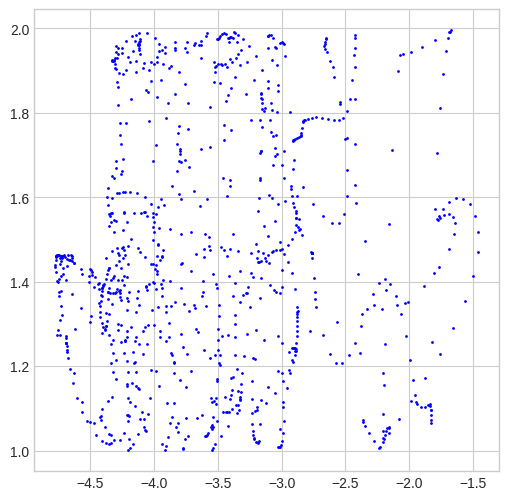

In [13]:
data_folder = "../data/interiornet/HD1"
id = "3FO4K35GPEA7"
cam_info_path = "velocity_angular"
traj = 7
light_type = "original"
id_length = 19

intrinsic = readCamIntrinsic(os.path.join(data_folder, id, f"{cam_info_path}_{traj}_{traj}", "cam0.info"))
#extrinsics_dict = parse_render_file(os.path.join(data_folder,id,f"{cam_info_path}_{traj}_{traj}","cam0.render"))
extrinsics_dict = parse_visim_file(os.path.join(data_folder,id,f"{cam_info_path}_{traj}_{traj}","cam0_gt.visim"))
timestamps = list(extrinsics_dict.keys())
print(f"Total {len(timestamps)} frames")

plt.figure(figsize=(6, 6))
plt.style.use("seaborn-v0_8-whitegrid")
for i, timestamp in enumerate(timestamps):
    extrinsic_matrix = extrinsics_dict[timestamp]
    camera_position = extrinsic_matrix[:3, 3]
    plt.scatter(camera_position[0], camera_position[2], color='blue', s=1)

## 1. Visualize Data Sample

In [4]:
idx = random.randint(0, len(timestamps)-1)
print("Frame id:", timestamps[idx])

rgb = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","cam0","data",f"{timestamps[idx]:019d}.png"))
depth = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","depth0","data",f"{timestamps[idx]:019d}.png"))
vs = np.array(
    [(v - intrinsic[0, 2]) / intrinsic[0, 0] for v in range(0, depth.shape[1])])
us = np.array(
    [(u - intrinsic[1, 2]) / intrinsic[1, 1] for u in range(0, depth.shape[0])])
depth = np.sqrt(np.square(depth / 1000.0) /
    (1 + np.square(vs[np.newaxis, :]) + np.square(us[:, np.newaxis]))) * 1000

instance = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","label0","data",f"{timestamps[idx]:019d}_instance.png"))
nyu_id = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","label0","data",f"{timestamps[idx]:019d}_nyu.png"))
nyu_color = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","label0","data",f"{timestamps[idx]:019d}_nyu_mask.png"))

Frame id: 16231666688


/tmp/ipykernel_27751/454091335.py:137: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return imageio.imread(name)


Intrinsics of 405:
 [[600.   0. 320.]
 [  0. 600. 240.]
 [  0.   0.   1.]]
Extrinsics of 405 
 [[-6.63187054e-01  1.12793372e-01 -7.39905922e-01 -4.13712025e+00]
 [-7.48453818e-01 -9.99435511e-02  6.55612913e-01  4.89221478e+00]
 [ 7.53439655e-09  9.88579316e-01  1.50701792e-01  1.98474026e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 639.5, 479.5, -0.5)

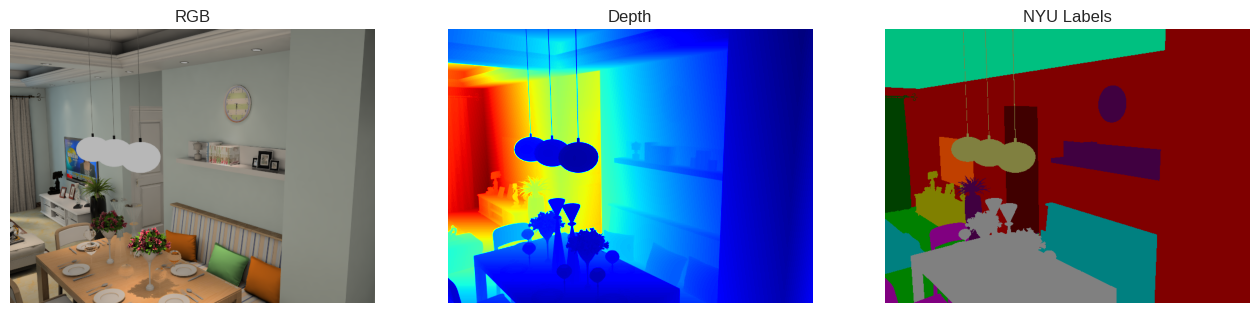

In [5]:
print(f"Intrinsics of {idx}:\n", intrinsic)
print(f"Extrinsics of {idx} \n", extrinsics_dict[timestamps[idx]])
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(16, 10))
plt.tight_layout()
plt.subplot(1, 3, 1)
plt.imshow(rgb)
plt.title("RGB")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(depth, cmap="jet")
plt.title("Depth")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(nyu_color)
plt.title("NYU Labels")
plt.axis("off")

## 2. Generate Point Cloud and Execute Voxelization

In [6]:
debug_num = 400

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
rgbs, depths, c2ws = [], [], []
for i in tqdm(range(0, debug_num, 2), desc="Loading Data"):
    rgb = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","cam0","data",f"{str(timestamps[i]).zfill(id_length)}.png"))
    depth = read(os.path.join(data_folder,id,f"{light_type}_{traj}_{traj}","depth0","data",f"{str(timestamps[i]).zfill(id_length)}.png"))
    vs = np.array(
        [(v - intrinsic[0, 2]) / intrinsic[0, 0] for v in range(0, depth.shape[1])])
    us = np.array(
        [(u - intrinsic[1, 2]) / intrinsic[1, 1] for u in range(0, depth.shape[0])])
    depth = np.sqrt(np.square(depth / 1000.0) /
        (1 + np.square(vs[np.newaxis, :]) + np.square(us[:, np.newaxis])))

    c2w = extrinsics_dict[timestamps[i]]
    
    rgbs.append(torch.tensor(rgb, dtype=torch.float32, device=device).permute(2, 0, 1))
    depths.append(torch.tensor(depth[None], dtype=torch.float32, device=device))
    c2ws.append(torch.tensor(c2w, dtype=torch.float32, device=device))

rgbs = torch.stack(rgbs, dim=0)
depths = torch.stack(depths, dim=0)
c2ws = torch.stack(c2ws, dim=0)
N, _, H, W = rgbs.shape

In [8]:
# Assuming rgb is of shape (N, 3, H, W), depth is of shape (N, 1, H, W), and c2w is of shape (N, 4, 4)
p_world, rgb_world = RGBD2PCD(rgbs, depths, intrinsic, c2ws)  # Shape: (N, H*W, 3), (N, H*W, 3)
del depths, c2ws

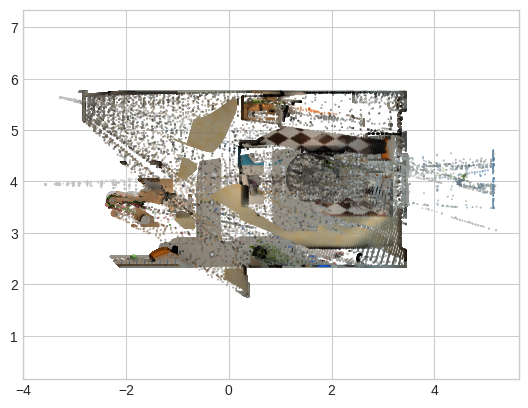

In [9]:
interval = N // 2
pcd_xyz = p_world.reshape(-1, 3).cpu().numpy()[::interval]
pcd_rgb = rgb_world.reshape(-1, 3).cpu().numpy()[::interval]
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=np.float64(pcd_rgb) / 255.0, s=0.1)
plt.axis("equal")
plt.show()

In [10]:
from plyfile import PlyData, PlyElement
# 确保输入数组形状正确
assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
if pcd_rgb.dtype != np.uint8:
    if np.max(pcd_rgb) <= 1.0:
        pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
    else:
        pcd_rgb = pcd_rgb.astype(np.uint8)

# 创建结构化数组
vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# 填充数据
vertices['x'] = pcd_xyz[:, 0].astype('f4')
vertices['y'] = pcd_xyz[:, 1].astype('f4')
vertices['z'] = pcd_xyz[:, 2].astype('f4')
vertices['red'] = pcd_rgb[:, 0]
vertices['green'] = pcd_rgb[:, 1]
vertices['blue'] = pcd_rgb[:, 2]

# 生成并保存PLY文件
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element]).write('colored_point_cloud.ply')